### Прогнозирование среднемесячной зарплаты в России

In [1]:
%pylab inline
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
from itertools import product

def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

Populating the interactive namespace from numpy and matplotlib


In [2]:
data = pd.read_csv('WAG_C_M.csv', sep=';', index_col=['month'], parse_dates=['month'], dayfirst=True)

In [3]:
data.head()

,WAG_C_M
month,
1993-01-01,15.3
1993-02-01,19.1
1993-03-01,23.6
1993-04-01,30.6
1993-05-01,37.5


#### 1. Визуальный анализ ряда

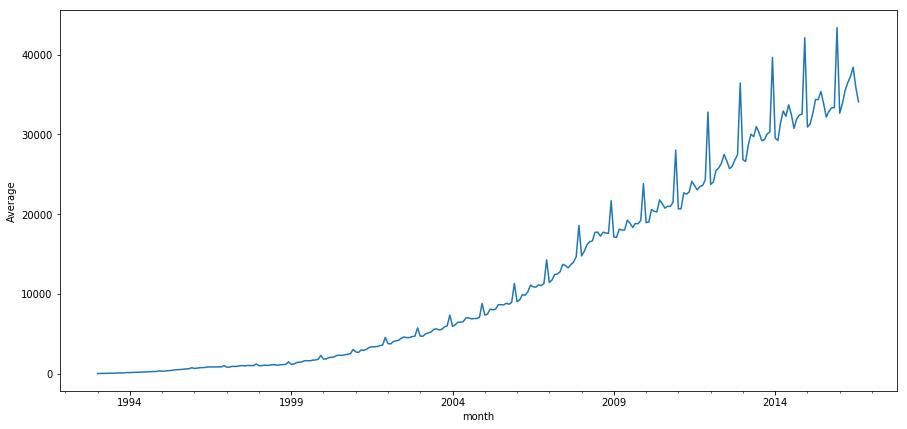

In [4]:
plt.figure(figsize(15,7))
data['WAG_C_M'].plot()
plt.ylabel('Average')
pylab.show()

In [5]:
# Визуальный аналих ряда свидетельствует о его нестационарности (возрастающая дисперсия, сезонность, наличие тренда).
# Убедимся в этом с помощью критерия Дики-Фуллера, а также произведем декомпозицию ряда на тренд, сезонность и остатки.

Критерий Дики-Фуллера: p=0.991850


<Figure size 1080x720 with 0 Axes>

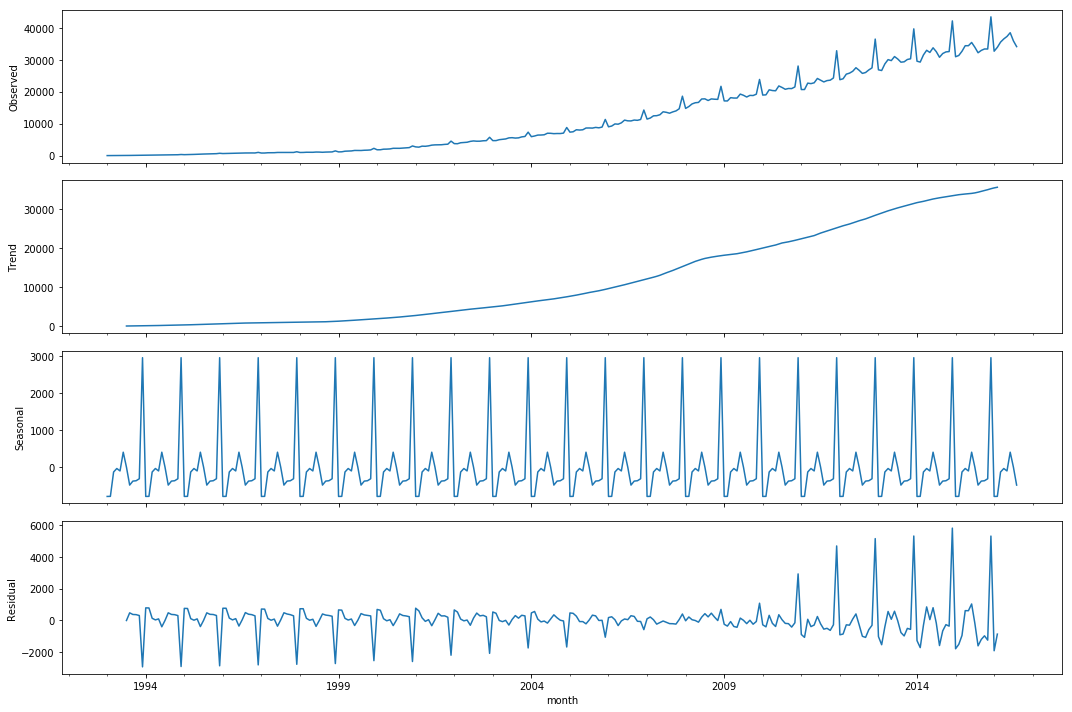

In [6]:
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(data['WAG_C_M']).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data['WAG_C_M'])[1])

In [7]:
# Критерий Дики-Фуллера не отвергает гипотезу о нестационарности ряда. 
# Также хорошо виден возрастающий тренд и сезонность. 
# В остатках видна структура

#### 2. Стабилизация дисперсии

In [8]:
# Попробуем стабилизировать дисперсию

Оптимальный параметр преобразования Бокса-Кокса: 0.263202
Критерий Дики-Фуллера: p=0.696899


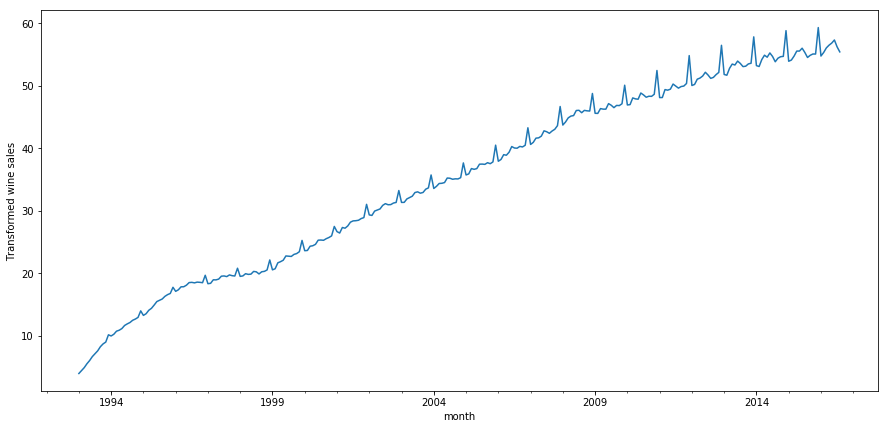

In [9]:
data['salary_box'], lmbda = stats.boxcox(data['WAG_C_M'])
plt.figure(figsize(15,7))
data['salary_box'].plot()
plt.ylabel(u'Transformed wine sales')
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data['salary_box'])[1])

In [11]:
# В результате преобразования Бокса-Кокса вариация дисперсии визуально уменьшилась, уменьшился и достигаемый уровень значимости
# критерия Дики-Фуллера о нестационарности ряда, однако он все равно слишком велик.

#### 3. Выбор порядка дифференцирования

In [12]:
# Выполним снаначла сезонное дифференцирование и если
# ряд останется нестационарным, выполним обычное дифференцирование 

Критерий Дики-Фуллера: p=0.019634


<Figure size 1080x720 with 0 Axes>

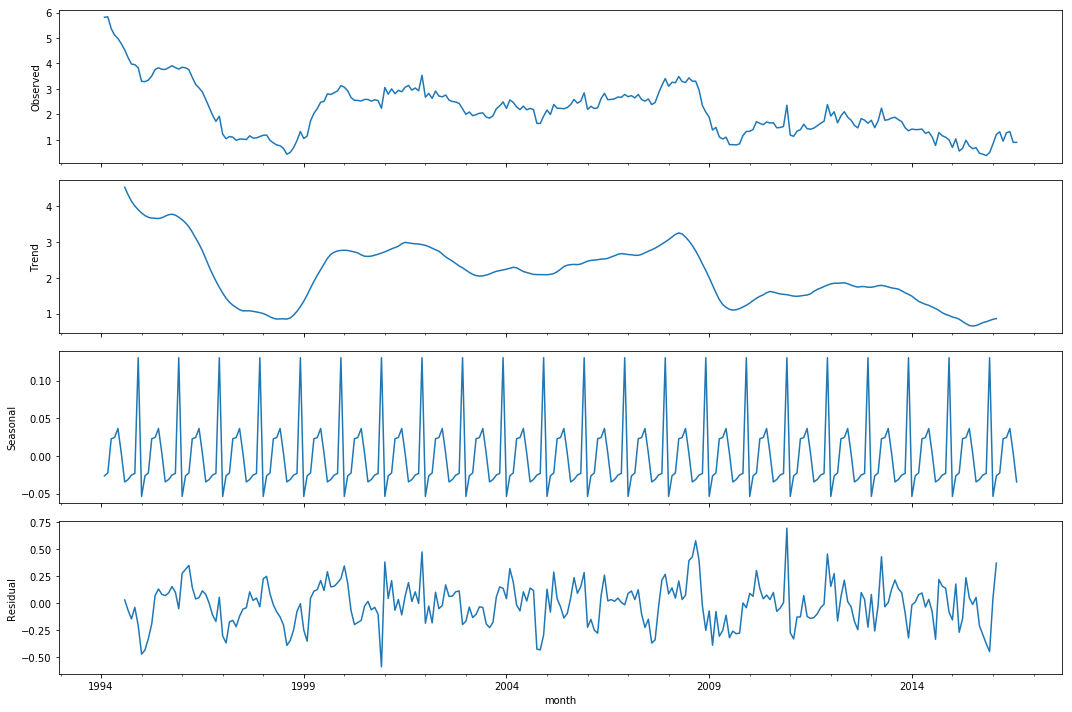

In [13]:
data['salary_box_diff'] = data['salary_box'] - data['salary_box'].shift(12)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(data['salary_box_diff'][13:]).plot()   
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data['salary_box_diff'][13:])[1])

In [14]:
# После сезонного дифференцирования видим, что тренд перестал иметь четкое направление,
# структура в остатках исчезла и они стали больше похожи на шум
# Критерий Дики-Фуллера отвергает гипотезу о нестацонарности ряда на уровне значимости 0.05

#### 4. Выбор начальных приближений для p,q,P,Q

In [15]:
# Посмотрим на ACF и PACF полученного ряда:

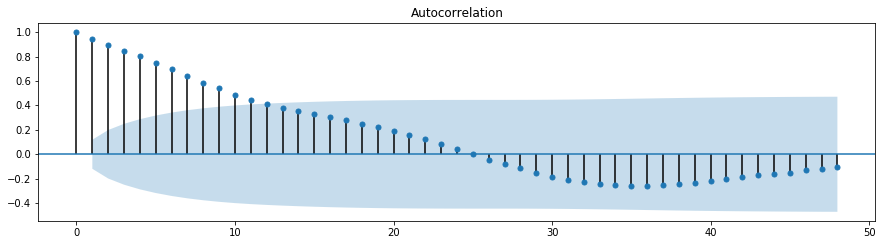

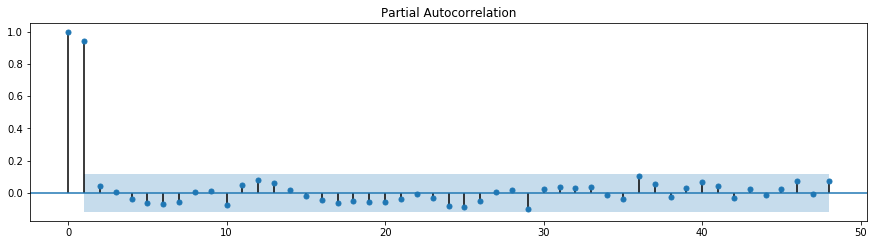

In [16]:
row = data['salary_box_diff']

plt.figure(figsize(15,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(row[13:].values.squeeze(), lags=48, ax=ax)
pylab.show()

ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(row[13:].values.squeeze(), lags=48, ax=ax)
pylab.show()

In [17]:
# Ищем начальные приближения для Q, q, P, p

# Q
# Начальное значение для параметра Q * S даёт номер последнего сезонного лага, при котором
# автокорреляция значима. В рассматриваемом примере сезонных даг со значимой корреляцией равен 12,
# значит, начальное приближение Q = 1.

# q
# Параметр q задаётся номером последнего несезонного лага, при котором
# автокорреляция значима. В данном случае можно взять начальное значение q = 11

# P
# Начальное приближение для параметра P ∗ S задаёт номер последнего сезонного лага, при котором частич-
# ная автокорреляция значима. В данных из примера это лаг под номером 36 (он находится на самой границе значимости),
# значит начальное приближение P = 3, поскольку длина сезонного периода S = 12.

# p
# p задаётся как номер последнего несезонного лага, при котором частичная автокорреляция значима. 
# В данном случае можно взять начальное приближение p = 1.

In [18]:
# Итак Q = 1, q = 11, P = 3, p = 1
ps=range(0, 2)
d=0 # порядок несезонного дифференцирования
qs=range(0, 12)
Ps=range(0, 4)
D=1 # порядок сезонного дифференцирования
Qs=range(0, 2)

#### 5. Обучение и сравнение моделей-кандидатов, выбор победителя

In [19]:
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
print len(parameters_list)

192


In [20]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')
row = data['salary_box']

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(row, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        #print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

Wall time: 13min 4s


In [21]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

        parameters        aic
88    (1, 9, 2, 1) -13.535321
95   (1, 10, 2, 1) -12.486060
90    (1, 9, 3, 1) -12.218358
97   (1, 10, 3, 1) -11.095133
102  (1, 11, 2, 1) -10.213652


In [22]:
# лучшая модель
print(best_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                         salary_box   No. Observations:                  284
Model:             SARIMAX(1, 0, 9)x(2, 1, 1, 12)   Log Likelihood                  20.768
Date:                            Mon, 20 May 2019   AIC                            -13.535
Time:                                    21:31:35   BIC                             36.946
Sample:                                01-01-1993   HQIC                             6.731
                                     - 08-01-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9856      0.007    133.917      0.000       0.971       1.000
ma.L1         -0.1818      0.051   

#### 6. Анализ остатков построенной модели

Критерий Стьюдента: p=0.340543
Критерий Дики-Фуллера: p=0.000000


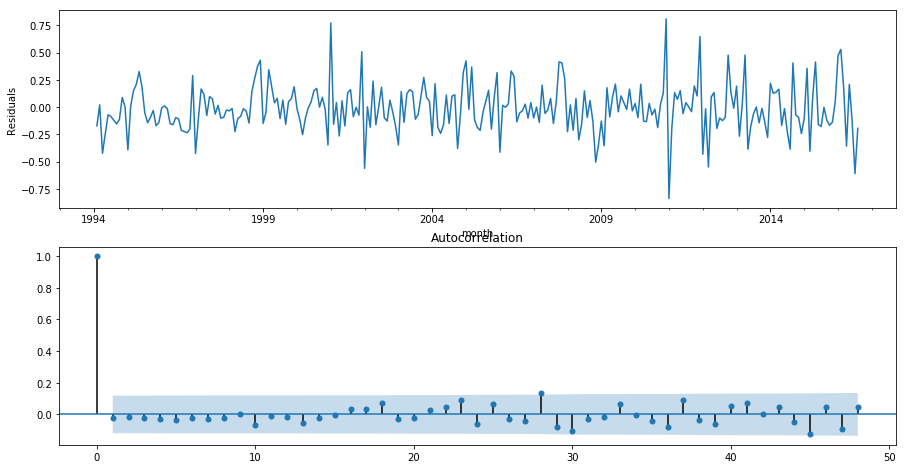

In [23]:
plt.figure(figsize(15,8))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[13:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

In [24]:
# Остатки несмещены (подтверждается критерием Стьюдента),
# стационарны (подтверждается критерием Дики-Фуллера и визуально), 
# неавтокоррелированы (подтверждается критерием Льюнга-Бокса и коррелограммой).
# Посмотрим, насколько хорошо модель описывает данные

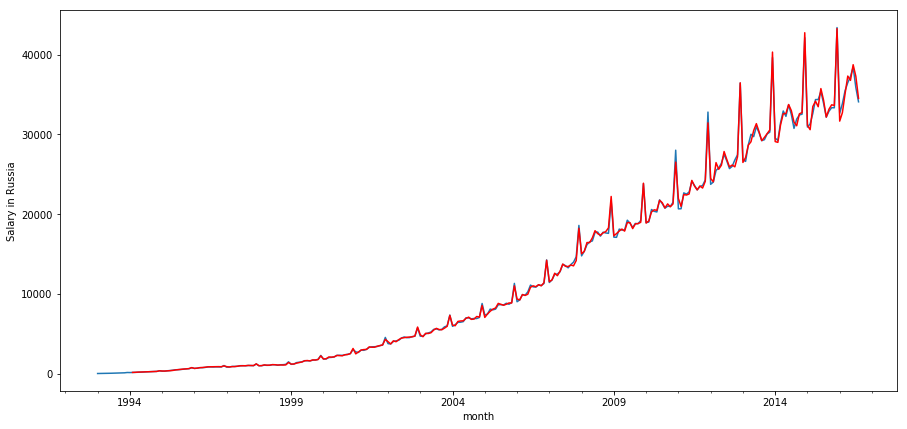

In [25]:
data['model'] = invboxcox(best_model.fittedvalues, lmbda)
plt.figure(figsize(15,7))
data['WAG_C_M'].plot()
data['model'][13:].plot(color='r')
plt.ylabel('Salary in Russia')
pylab.show()

In [26]:
# Как видим, модель неплохо приближает исходные данные

#### 7.Прогнозирование с помощью финальной модели.

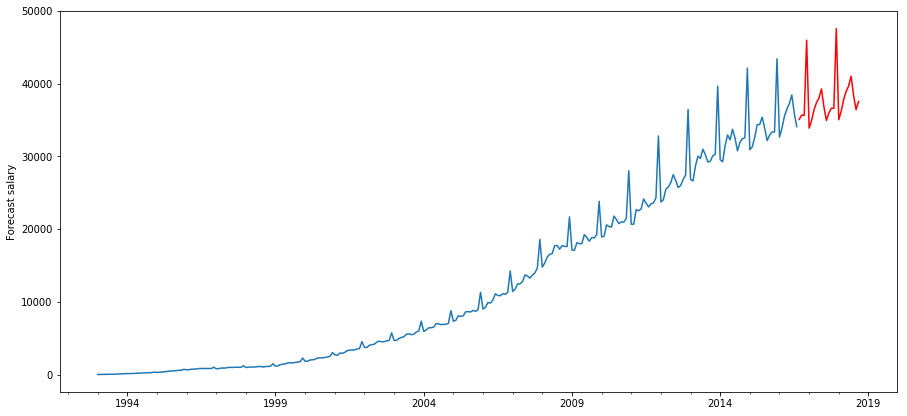

In [27]:
forecast_period = 24

salary2 = data[['WAG_C_M']]
date_list = [datetime.datetime.strptime('2016-09-01','%Y-%m-%d')+relativedelta(months=x) for x in range(0,forecast_period+1)]
future = pd.DataFrame(index=date_list, columns=salary2.columns)
salary2 = pd.concat([salary2, future])
salary2['forecast'] = invboxcox(best_model.predict(start=284, end=284+forecast_period), lmbda)

plt.figure(figsize(15,7))
salary2['WAG_C_M'].plot()
salary2['forecast'].plot(color='r')
plt.ylabel('Forecast salary')
pylab.show()

In [28]:
# Прогноз выгдядит адекватно